In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

    
# Target image dimensions
img_height, img_width = 300, 300

def get_image_data():
    
    # Generate dataset from local image files
    ds = image_dataset_from_directory(
        'CUB_200_2011/images',
        image_size = (img_height, img_width),
        label_mode='categorical',
        validation_split=.017,
        subset="validation",
        shuffle=False,
        batch_size=8,
        seed=420,)
    
    # Get numpy array from tf.dataset.Dataset object 
    images = []
    labels = []
    for X, y in ds.as_numpy_iterator():
        images.extend(X)
        labels.append(y)

    return np.array(images), np.array(labels), ds.file_paths

images, labels, paths = get_image_data()
images.shape

Found 11788 files belonging to 200 classes.
Using 200 files for validation.


(200, 300, 300, 3)

In [3]:
from PIL import Image

# Get original image sizes
sizes = [Image.open(file).size for file in paths]
sizes[:5]

[(500, 332), (357, 500), (350, 500), (500, 500), (324, 500)]

In [4]:
import pandas as pd

def get_bboxes():
    
    # Load in bounding boxes
    bbox_dir = 'CUB_200_2011/bounding_boxes.txt'
    bboxes = pd.read_csv(bbox_dir, 
                         index_col=0,
                         delimiter=" ", 
                         names=['x','y','width','height'])

    # Slice last 200 rows to get values for validation split when shuffle=False
    size = 200
    bboxes = bboxes.iloc[-size:]

    # Arrays for image sizes
    image_widths = np.zeros(size) + img_width
    image_heights = np.zeros(size) + img_height

    # Original image sizes
    original_widths = np.array([w for w, h in sizes])
    original_heights = np.array([h for w, h in sizes])

    # Find Scale factor for height/width of each image
    scale_factors = [image_widths / original_widths,
                     image_heights / original_heights]

    # Scale bounding box values
    for i, col in enumerate(bboxes.columns):

        bboxes[col+"_scaled"] = bboxes[col] * scale_factors[i % 2]
    
    
    return bboxes

bboxes = get_bboxes()
bboxes.head()

,x,y,width,height,x_scaled,y_scaled,width_scaled,height_scaled
11589,137.0,93.0,184.0,211.0,82.200000,84.036145,110.400000,190.662651
11590,81.0,81.0,221.0,221.0,68.067227,48.600000,185.714286,132.600000
11591,115.0,138.0,175.0,291.0,98.571429,82.800000,150.000000,174.600000
11592,100.0,109.0,196.0,216.0,60.000000,65.400000,117.600000,129.600000
11593,45.0,73.0,314.0,341.0,41.666667,43.800000,290.740741,204.600000


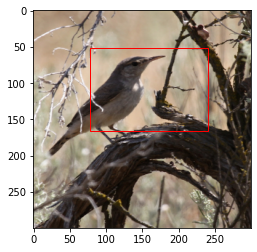

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


index = 32
original = False

# Create figure and axes
fig, ax = plt.subplots()


if original:
    image = Image.open(paths[index])
    x, y, w, h = bboxes.iloc[index,:4].values
    
else:
    image = images[index] / 255
    x, y, w, h = bboxes.iloc[index,4:].values

# Bounding box    
bbox = Rectangle((x, y), w, h, 
                 linewidth=1, 
                 edgecolor='r', 
                 facecolor='none')

ax.imshow(image)
ax.add_patch(bbox)
plt.show()

In [6]:
from tensorflow.keras.applications import EfficientNetB3

# Load pretrained model
base = EfficientNetB3()

In [7]:
from tensorflow.keras import layers
tf.keras.backend.clear_session()


def build_small_model(EfficientNetB3=EfficientNetB3):
    
    # Define pretrained base
    base = EfficientNetB3()
    
    # Freeze pretrained layers
    for pretrained_layer in base.layers:
        pretrained_layer.trainable = False

    # Output from pretrained base
    base_output = base.get_layer('block1b_add').output
    
    # Size reduction layers
    pool_1 = layers.AveragePooling2D(5, 5)(base_output)
    conv_final = layers.Conv2D(16, 4)(pool_1)
    pool_2 = layers.MaxPooling2D(3, 2)(conv_final)
    flatten = layers.Flatten()(pool_2)
    
    # Branch hidden layers
    y1_hidden = layers.Dense(5, activation='relu')(flatten)
    y2_hidden = layers.Dense(5, activation='relu')(flatten)
    y3_hidden = layers.Dense(5, activation='relu')(flatten)
    y4_hidden = layers.Dense(5, activation='relu')(flatten)
    
    # Output layers
    output1 = layers.Dense(1, name='output1')(y1_hidden)
    output2 = layers.Dense(1, name='output2')(y2_hidden)
    output3 = layers.Dense(1, name='output3')(y3_hidden)
    output4 = layers.Dense(1, name='output4')(y4_hidden)
    
    # Build final model using functional api 
    model = tf.keras.Model(base.input, [output1, output2, output3, output4])
    
    return model


model = build_small_model()

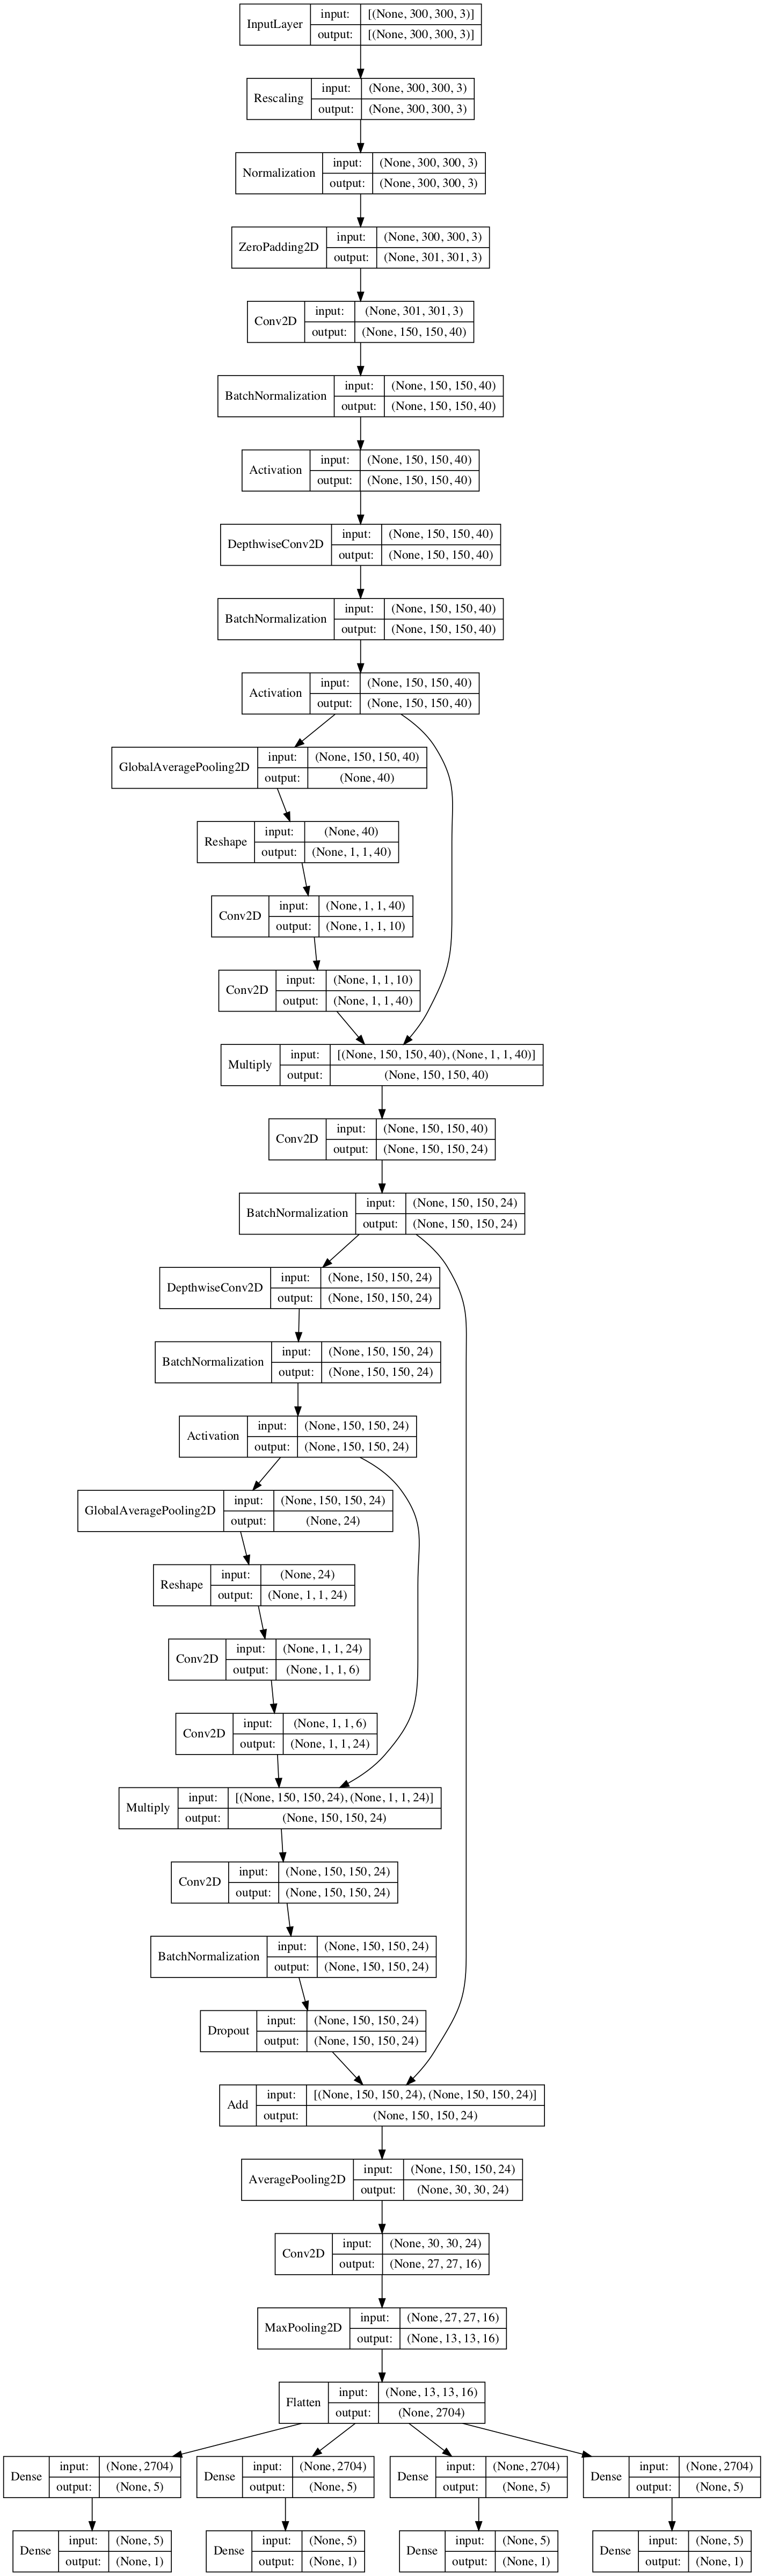

In [8]:
from tensorflow.keras.utils import plot_model

# Inspect architecture
plot_model(model, dpi=120, show_shapes=True, show_layer_names=False)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [10]:
# Callbacks to be called during training 
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='loss'),
checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoints"),
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=4, 
                                                 min_lr=1e-5, 
                                                 monitor='loss'),

In [11]:
from tensorflow.keras.losses import MeanSquaredError


# Scaled X, Y, width and height for bboxes
outputs = (bboxes.iloc[:,4] / img_width,
           bboxes.iloc[:,5] / img_height,
           bboxes.iloc[:,6] / img_width,
           bboxes.iloc[:,7] / img_height,)


# Loss function for our 4 model outputs
mse = MeanSquaredError()

# Dict for each output loss function
losses = {f'output{i+1}': mse for i in range(4)}

model.compile(optimizer='adam', loss=losses)

history = model.fit(images, 
                    outputs, 
                    epochs=15, 
                    batch_size=8, 
                    callbacks=[early_stop,
                               checkpoint,
                               reduce_lr])

Epoch 1/15
25/25 [==============================] - 9s 259ms/step - loss: 54.3180 - output1_loss: 0.2606 - output2_loss: 6.1908 - output3_loss: 46.7323 - output4_loss: 1.1343
INFO:tensorflow:Assets written to: checkpoints/assets
Epoch 2/15
25/25 [==============================] - 7s 264ms/step - loss: 0.7435 - output1_loss: 0.0248 - output2_loss: 0.0643 - output3_loss: 0.2765 - output4_loss: 0.3779
INFO:tensorflow:Assets written to: checkpoints/assets
Epoch 3/15
25/25 [==============================] - 7s 268ms/step - loss: 0.7411 - output1_loss: 0.0199 - output2_loss: 0.0604 - output3_loss: 0.2825 - output4_loss: 0.3783
INFO:tensorflow:Assets written to: checkpoints/assets
Epoch 4/15
25/25 [==============================] - 7s 262ms/step - loss: 0.6555 - output1_loss: 0.0206 - output2_loss: 0.0611 - output3_loss: 0.2621 - output4_loss: 0.3117
INFO:tensorflow:Assets written to: checkpoints/assets
Epoch 5/15
25/25 [==============================] - 7s 262ms/step - loss: 0.6103 - output1

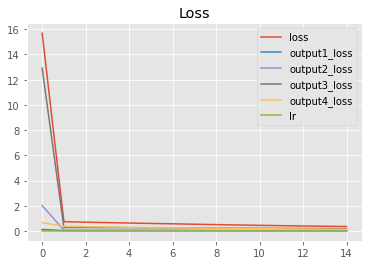

In [12]:
def plot_results():
    # Plot results
    plt.style.use('ggplot')
    hist_df = pd.DataFrame(history.history)
    hist_df.plot(title='Loss');
    
plot_results()